In [8]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display

import photRM # our functions

sns.set_style('ticks')

# DLE-PhotoRM

## 1. Motivation

Exploring transient optical sky (ETOS) is among four Rubin Observatory Legacy Survey of Space and Time (LSST) key science drivers (Ivezić et al. 2019). We are motivated by the ETOS LSST science opportunity No. 14 (see item 14 in section 4, Ivezić et al. 2019), which enables to harness LSST light curves of active galactic nuclei (AGN) for photometric reverberation mapping (PhotoRM, Chelouche & Daniel 2012, Edri et al. 2012). We are developing deep learning engines (DLEs) for non-parametric modeling and extracting of information from AGN light-curves, which are directly related to the scientific objectives of the LSST Exploring transient optical sky.

Here, we present our implementation of PhotoRM method. The goal of PhotoRM is to calculate the broad line region radius using broadband photometric filters. For example, if we consider a low redshift ($z = 0.005$) AGN, the continuum emission is covered by the $i$-band, and H$\alpha$ and H$\beta$ line emission superimposed on the continuum is covered by the $r$ and $g$ bands, respectively. Contrary to the spectroscopic light curves, photometric light curves contain both continuum and line emission, so classical cross-correlation is not applicable to those light curves. That is why we use the formalism (Edri et al. 2012, Chelouche & Daniel 2012), in which the time lag between the continuum and emission line is obtained by looking for a peak in the difference between cross-correlation and auto-correlation functions of light curves in specific filters covering continuum and continuum + line emission. The crux of this method is the following formula:

$$
\begin{align}
CCF(\tau) = CCF(\mathrm{continuum \ \& \ line}) - ACF(\mathrm{continuum})
\end{align}
$$


$ACF$ - auto-correlation function  
$CCF$ - cross-corelation function  
$\tau$ - time-lag between continuum and line emission.

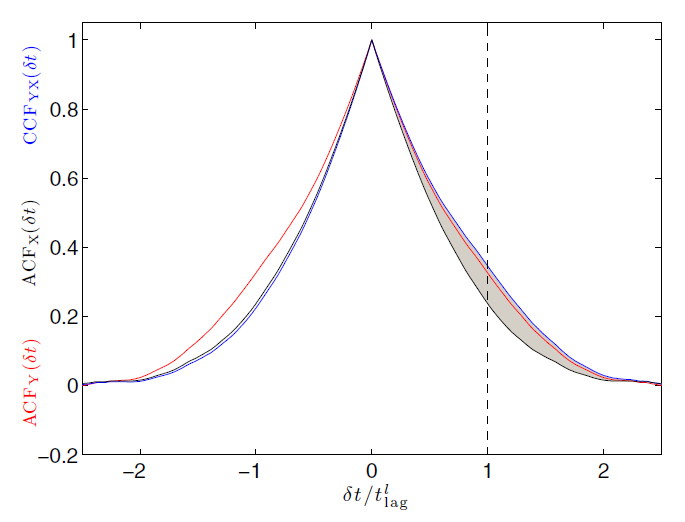

In [18]:
display.Image("./ilustracija.png")

<center>Chelouche & Daniel (2012)</center>

## 2. Data

In this example, we will use light curve data from Edri et al. (2012) to demonstrate our PhotoRM implementation. These authors performed the monitoring of NGC 4395 for 9 consecutive nights using the Wise's Observatory's 1m telescope equipped with the SDSS $g$, $r$ and $i$ broadband filters. In addition to observational data, we complement our analysis by applying PhotoRM to "learned" light curves of NGC 4395 obtained from convolutional neural network developed in DLE1.

To summerize, we apply our PhotoRM procedure to two datasets:

- observational data of NGC 4395 in $g$, $r$ and $i$ bands
- NGC 4395 light curve models ($g$, $r$ and $i$ bands) obtained from conditional neural process (DLE1)

## 3.  Choosing LSST filters for PhotoRM

Before we start with the analysis, we first need to choose appropriate filters for PhotoRM purposes:

- The first filter needs to cover exclusively the **continuum emission**, in our case this is the **$i$ - band**;
- The second filter has to cover **line emission + continuum emission**. Here, we choose the **$r$ - band** which contains H$\alpha$ emission.
- Alternative to the line + continuum emission is the $g$ filter, covering the H$\beta$ emission line. 

The function `lsst_filters_viz()` demonstrates how choice of appropriate filters changes with redshift, for the case of LSST filters. For example, if we set $z = 1.5$, the *r*-band no longer covers the H$\alpha$ emission, and we need to resort to other emission lines available in the optical range. In this case, we may use the *g*-band for line + continuum emission (covering C III) and *z*-band for continuum emission only.

Our object, NGC 4395, has $z=0.001$ so we plot the composite spectrum at this redshift together with the LSST braodband filters response curves.

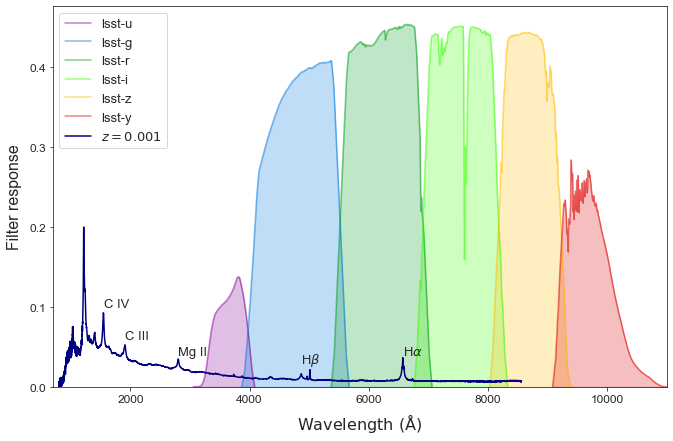

In [2]:
photRM.filters_viz(z=0.001, phot_sys='LSST', save=True)

## 4. Light curve preparation

After filter selection, we can read the appropriate data and begin the pre-processing phase. In this step, you may want to:

- Read your data;
- Convert the units of time and/or intensity for the given light curve;
- Convert magnitude to flux, or vice versa. 

### 4.1 Data reading

We will read the observational data in all three filters, and store them into three dataframes. We also read the model light curves, obtained by using a convolutional neural network, for later comparison.

In [3]:
# Light curve 1 (contains emisson line):
r = pd.read_csv('lc_r.txt', header=0, sep=" ", skipinitialspace=True, usecols=[0,1,2])

# Light curve 2 (contains only continuum):
i = pd.read_csv('lc_i.txt', header=0, sep=" ", skipinitialspace=True, usecols=[0,1,2])

# Additional light curves for testing
g = pd.read_csv('lc_g.txt', header=0, sep=" ", skipinitialspace=True, usecols=[0,1,2])

# Light curves from CNN --> flux
r_cnn = pd.read_csv('results_CNN/r_flux.txt', header=0, sep=" ", skipinitialspace=True)
i_cnn = pd.read_csv('results_CNN/i_flux.txt', header=0, sep=" ", skipinitialspace=True)
g_cnn = pd.read_csv('results_CNN/g_flux.txt', header=0, sep=" ", skipinitialspace=True)

# Light curves from CNN --> flux(8h)
r_cnn8 = pd.read_csv('results_CNN/r_flux_8_hours.txt', header=0, sep=" ", skipinitialspace=True)
i_cnn8 = pd.read_csv('results_CNN/i_flux_8_hours.txt', header=0, sep=" ", skipinitialspace=True)
g_cnn8 = pd.read_csv('results_CNN/g_flux_8_hours.txt', header=0, sep=" ", skipinitialspace=True)

For example, let's look at the $r$-band data. Time is in MJD, so maybe we would like to have a more useful unit, like days or hours from the first observation. We will do the conversion in the next step (Section 3.2).

In [4]:
r.head()

,MJD,mag,mag_err
0,2.455616e+06,16.272,0.027
1,2.455616e+06,16.270,0.026
2,2.455616e+06,16.263,0.022
3,2.455616e+06,16.260,0.021
4,2.455616e+06,16.251,0.021


### 4.2 Light curve pre-processing

- Our function `MJD_convert()` can convert Modified Julian Date to days or hours, starting from the first observation in the given array.

- We also provide a function for conversion of SDSS magnitudes to flux - `mag_to_flux()`, and vice versa - `flux_to_mag()`.

- In addition, you can call the `lc_prep()` function to do it all together.

You can use the above functions in the following way:

In [5]:
# Input:
lcs = [r,i,g]
filters = ['r','i','g']
time = 'hours' # {'hours', 'days'}

# We will do conversions for all three filters
for lc, filt in zip(lcs, filters):
    t, intensity = photRM.lc_prep(lc['MJD'], lc['mag'],
                           filt=filt,
                           mag_flux=True, 
                           mjd_convert=True, 
                           time=time)
    
    # Add new columns to dataframes:
    lc['time_{}'.format(time)] = t
    lc['flux'] = intensity
    # Calculate flux error using formula obtained by error propagation (mag. err. = flux_err/flux)
    lc['flux_err'] = lc['flux'] * np.abs(lc['mag_err'])
    # Calculate error in percents
    #err_perc = lc['flux_err']/lc['flux']
    # Add normalized flux and its error
    lc['norm_flux'] = (lc['flux'] - lc['flux'].min())/(lc['flux'].max() - lc['flux'].min()) # add normalized flux
    lc['norm_flux_err'] = (1/(lc['flux'].max()-lc['flux'].min()))*lc['flux_err']
    
lcs = [r,i,g]

Let's look again the $r$-band light curve data. We now have additional columns and we can choose to keep all of them or not. I like to have them all for reference :)

In [6]:
r.head()

,MJD,mag,mag_err,time_hours,flux,flux_err,norm_flux,norm_flux_err
0,2.455616e+06,16.272,0.027,0.00000,2577.507870,69.592712,0.367951,0.139859
1,2.455616e+06,16.270,0.026,0.46464,2582.260191,67.138765,0.377501,0.134927
2,2.455616e+06,16.263,0.022,0.69696,2598.962421,57.177173,0.411067,0.114907
3,2.455616e+06,16.260,0.021,0.92928,2606.153550,54.729225,0.425519,0.109988
4,2.455616e+06,16.251,0.021,1.16160,2627.846541,55.184777,0.469115,0.110903


In [7]:
r.head()

,MJD,mag,mag_err,time_hours,flux,flux_err,norm_flux,norm_flux_err
0,2.455616e+06,16.272,0.027,0.00000,2577.507870,69.592712,0.367951,0.139859
1,2.455616e+06,16.270,0.026,0.46464,2582.260191,67.138765,0.377501,0.134927
2,2.455616e+06,16.263,0.022,0.69696,2598.962421,57.177173,0.411067,0.114907
3,2.455616e+06,16.260,0.021,0.92928,2606.153550,54.729225,0.425519,0.109988
4,2.455616e+06,16.251,0.021,1.16160,2627.846541,55.184777,0.469115,0.110903


Model light curves are already stored in correct format (hours and flux), we only need to do flux normalization.

In [8]:
lcs_cnn = [r_cnn, i_cnn, g_cnn]
lcs_cnn8 = [r_cnn8, i_cnn8, g_cnn8]
filters = ['r','i','g']
time = 'hours'

for lc, filt in zip(lcs_cnn, filters):
    lc['norm_flux'] = (lc['flux'] - lc['flux'].min())/(lc['flux'].max() - lc['flux'].min())
    
for lc,filt in zip(lcs_cnn8, filters):
    # Calculate error in percents
    err_perc = lc['conf']/lc['flux']
    # Add normalized flux and its error
    lc['norm_flux'] = (lc['flux'] - lc['flux'].min())/(lc['flux'].max() - lc['flux'].min()) # add normalized flux
    lc['norm_flux_err'] = (1/(lc['flux'].max()-lc['flux'].min()))*lc['conf']

In [9]:
lcs_cnn8 = [r_cnn8, i_cnn8, g_cnn8]
g_cnn8_zdcf = g_cnn8[['time_hours','norm_flux','norm_flux_err']].round(decimals=6)
r_cnn8_zdcf = r_cnn8[['time_hours','norm_flux','norm_flux_err']].round(decimals=6)
i_cnn8_zdcf = i_cnn8[['time_hours','norm_flux','norm_flux_err']].round(decimals=6)

g_cnn8_zdcf.to_csv('g_nflux_cnn8_zdcf.txt',sep=" ", index=False, header=False)
r_cnn8_zdcf.to_csv('r_nflux_cnn8_zdcf.txt',sep=" ", index=False, header=False)
i_cnn8_zdcf.to_csv('i_nflux_cnn8_zdcf.txt',sep=" ", index=False, header=False)

### 4.3 Light curve visualization

Now, let's check how our data looks like!

First, we plot the observed light curves in $r$,$i$ and $g$ band. Panels on the left show the curves obtained for the whole duration of the monitoring period. Shaded areas represents the data range we have chosen for further analysis. The first shaded area contains first ~8h of observations, and the second area envelops data obtained from the 70th to 130th hour of observations. The right panels show just the first 8 hours.

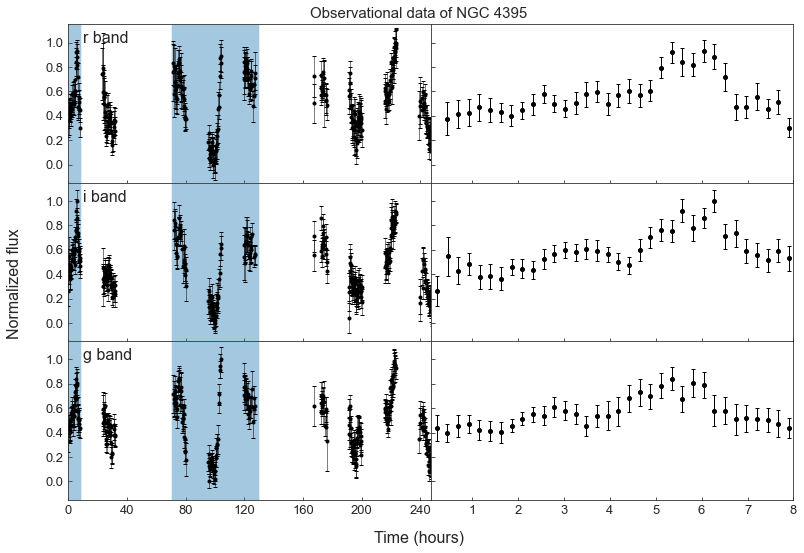

In [9]:
photRM.plot_obs_data(lcs, filters=['r','i','g'])

Now, we plot the learned light curve in $r$,$i$ and $g$ band against real data. Panels on the left show model light curves obtained for the whole duration of the monitoring period. As seen on the figure above, when neural network is applied to the whole data range, the model doesen't approximate quite well on small time scales (middle panels). That is why we apllied the neural network to first 8h separately (right panels).

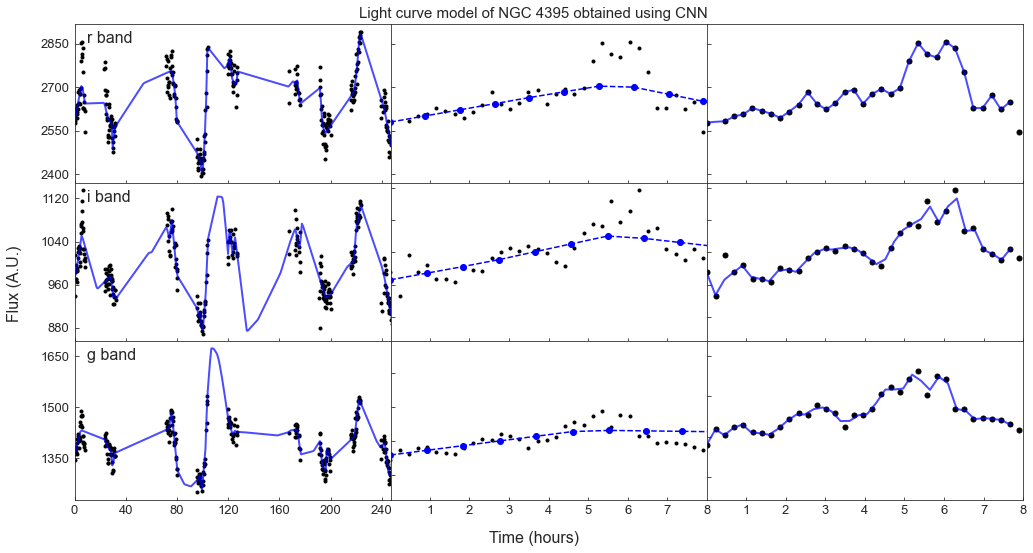

In [10]:
photRM.plot_cnn_data(lcs_cnn, lcs_cnn8, lcs, filters=['r','i','g'])

### 4.4. Defining light curve segments for later analysis

Next, we define segments (shaded areas from light curve plot). The first segment contains data from the first ~8h of observations and the second segment contains data in the time interval from ~70h to ~130h of observations.

In [15]:
# Segment 1
i_seg1 = i[:37]
r_seg1 = r[:35]
g_seg1 = g[:35]

# Segment 2
i_seg2 = i[72:153]
r_seg2 = r[71:163]
g_seg2 = g[68:154]

### 4.5 Saving processed data for CCF analysis

To obtain the time-lags, we use the Z-transformed Discrete Correlation Function (ZDCF, Alexander 1997). The input for the program needs to be a table with three columns: time (ordered), flux/magnitude, absolute error on flux/magnitude.

In [16]:
# Choose only necessery parameters for ZDCF input
i_zdcf = i[['time_hours','norm_flux', 'norm_flux_err']].round(decimals=5)
r_zdcf = r[['time_hours','norm_flux', 'norm_flux_err']].round(decimals=5)
g_zdcf = g[['time_hours','norm_flux', 'norm_flux_err']].round(decimals=5)

i_seg1 = i_seg1[['time_hours','norm_flux', 'norm_flux_err']].round(decimals=5)
r_seg1 = r_seg1[['time_hours','norm_flux', 'norm_flux_err']].round(decimals=5)
g_seg1 = g_seg1[['time_hours','norm_flux', 'norm_flux_err']].round(decimals=5)

i_seg2 = i_seg2[['time_hours','norm_flux', 'norm_flux_err']].round(decimals=5)
r_seg2 = r_seg2[['time_hours','norm_flux', 'norm_flux_err']].round(decimals=5)
g_seg2 = g_seg2[['time_hours','norm_flux', 'norm_flux_err']].round(decimals=5)

# Save pre-processed light curves
i_zdcf.to_csv('i_nflux_zdcf.txt',sep=" ", index=False, header=False)
r_zdcf.to_csv('r_nflux_zdcf.txt',sep=" ", index=False, header=False)
g_zdcf.to_csv('g_nflux_zdcf.txt',sep=" ", index=False, header=False)

i_seg1.to_csv('i_nflux_seg1.txt',sep=" ", index=False, header=False)
r_seg1.to_csv('r_nflux_seg1.txt',sep=" ", index=False, header=False)
g_seg1.to_csv('g_nflux_seg1.txt',sep=" ", index=False, header=False)

i_seg2.to_csv('i_nflux_seg2.txt',sep=" ", index=False, header=False)
r_seg2.to_csv('r_nflux_seg2.txt',sep=" ", index=False, header=False)
g_seg2.to_csv('g_nflux_seg2.txt',sep=" ", index=False, header=False)

## 5. Cross-correlation calculation using ZDCF (Alexander 1997)

We provide a simple routine for calling the program directly from this notebook. The results obtained by running ZDCF are stored in the same folder as this notebook.

In [75]:
def ZDCF():
    """
    This function simulates the ZDCF input prompts and calls the actual program
    compiled in fortran using the command line. The compiled program needs to be
    in the same directory as this notebook. The results are also stored in the
    current directory.
    """
    p1 = input("Auto-correlation or cross-correlation? (1/2)")
    p2 = input("Enter output files prefix:")
    p3 = input("Uniform sampling of light curve? (y/n)")
    p4 = input("Enter minimal number of points per bin (0 for default):")
    p5 = input("Omit zero-lag points? (y/n):")
    p6 = input("How many Monte Carlo runs for error estimation?")
    p7 = input("Enter name of 1st light curve file:")
    if p1 == '2':
        p8 = input("Enter name of 2nd light curve:")
        parameters = p1+'\n'+p2+'\n'+p3+'\n'+p4+'\n'+p5+'\n'+p6+'\n'+p7+'\n'+p8
    elif p1 == '1':
        parameters = p1+'\n'+p2+'\n'+p3+'\n'+p4+'\n'+p5+'\n'+p6+'\n'+p7
    !printf "{parameters}" | ./prog.out

It is very simple to run:

In [ ]:
ZDCF()

## 5. Results

### 5.1 Observational data - segments (0-8h & 70h-130h)

In the first part of the analysis, we will estimate the time-lags from two data segments.

First we need to read the results obtained from ZDCF. We already calculated the auto-correlation and cross-correlation functions for three filter combinations:

- ACF($i$) and CCF($i$ & $r$)
- ACF($g$) and CCF($g$ & $r$)
- ACF($i$) and CCF($i$ & $g$)

In the PhotoRM procedure described by Edri et al. (2012), the line-continuum cross-corelation function is obtained using the following formula:

$$
\begin{align}
CCF(\tau) = CCF(\mathrm{continuum \ \& \ line}) - ACF(\mathrm{continuum})
\end{align}
$$

The time-lag ($\tau$) is estimated by locating the first peak in the $CCF(\tau)$.

In [3]:
# Loading results: segment 1 (0h-8h)

ccf_ir1 = pd.read_csv('results_zdcf_segments_nflux/ccf_ir_err_seg1.dcf', sep=" ", header=None, skipinitialspace=True)
ccf_gr1 = pd.read_csv('results_zdcf_segments_nflux/ccf_gr_err_seg1.dcf', sep=" ", header=None, skipinitialspace=True)
ccf_ig1 = pd.read_csv('results_zdcf_segments_nflux/ccf_ig_err_seg1.dcf', sep=" ", header=None, skipinitialspace=True)

acf_i1 = pd.read_csv('results_zdcf_segments_nflux/acf_i_err_seg1.dcf', sep=" ", header=None, skipinitialspace=True)
acf_g1 = pd.read_csv('results_zdcf_segments_nflux/acf_g_err_seg1.dcf', sep=" ", header=None, skipinitialspace=True)
acf_r1 = pd.read_csv('results_zdcf_segments_nflux/acf_r_err_seg1.dcf', sep=" ", header=None, skipinitialspace=True)

ccfs1 = [ccf_ir1, ccf_gr1, ccf_ig1]
acfs1 = [acf_i1, acf_g1, acf_r1]

# Loading results: segment 2 (70h-130h)

ccf_ir2 = pd.read_csv('results_zdcf_segments_nflux/ccf_ir_err_seg2.dcf', sep=" ", header=None, skipinitialspace=True)
ccf_gr2 = pd.read_csv('results_zdcf_segments_nflux/ccf_gr_err_seg2.dcf', sep=" ", header=None, skipinitialspace=True)
ccf_ig2 = pd.read_csv('results_zdcf_segments_nflux/ccf_ig_err_seg2.dcf', sep=" ", header=None, skipinitialspace=True)

acf_i2 = pd.read_csv('results_zdcf_segments_nflux/acf_i_err_seg2.dcf', sep=" ", header=None, skipinitialspace=True)
acf_g2 = pd.read_csv('results_zdcf_segments_nflux/acf_g_err_seg2.dcf', sep=" ", header=None, skipinitialspace=True)
acf_r2 = pd.read_csv('results_zdcf_segments_nflux/acf_r_err_seg2.dcf', sep=" ", header=None, skipinitialspace=True)

ccfs2 = [ccf_ir2, ccf_gr2, ccf_ig2]
acfs2 = [acf_i2, acf_g2, acf_r2]

# Defining columns
cols = ['tau', '-sig(tau)', '+sig(tau)', 'dcf', '-err(dcf)', '+err(dcf)', '#bin']

for ccf1,ccf2,acf1,acf2 in zip(ccfs1,ccfs2,acfs1,acfs2):
    ccf1.columns = cols
    ccf2.columns = cols
    acf1.columns = cols
    acf2.columns = cols

In the following plots, we show the $CCF(\tau)$ in the bottom panel, and $ACFs$ and $CCFs$ used to obtain it are shown in the upper panels. We repeat the analysis for three different filter combinations.

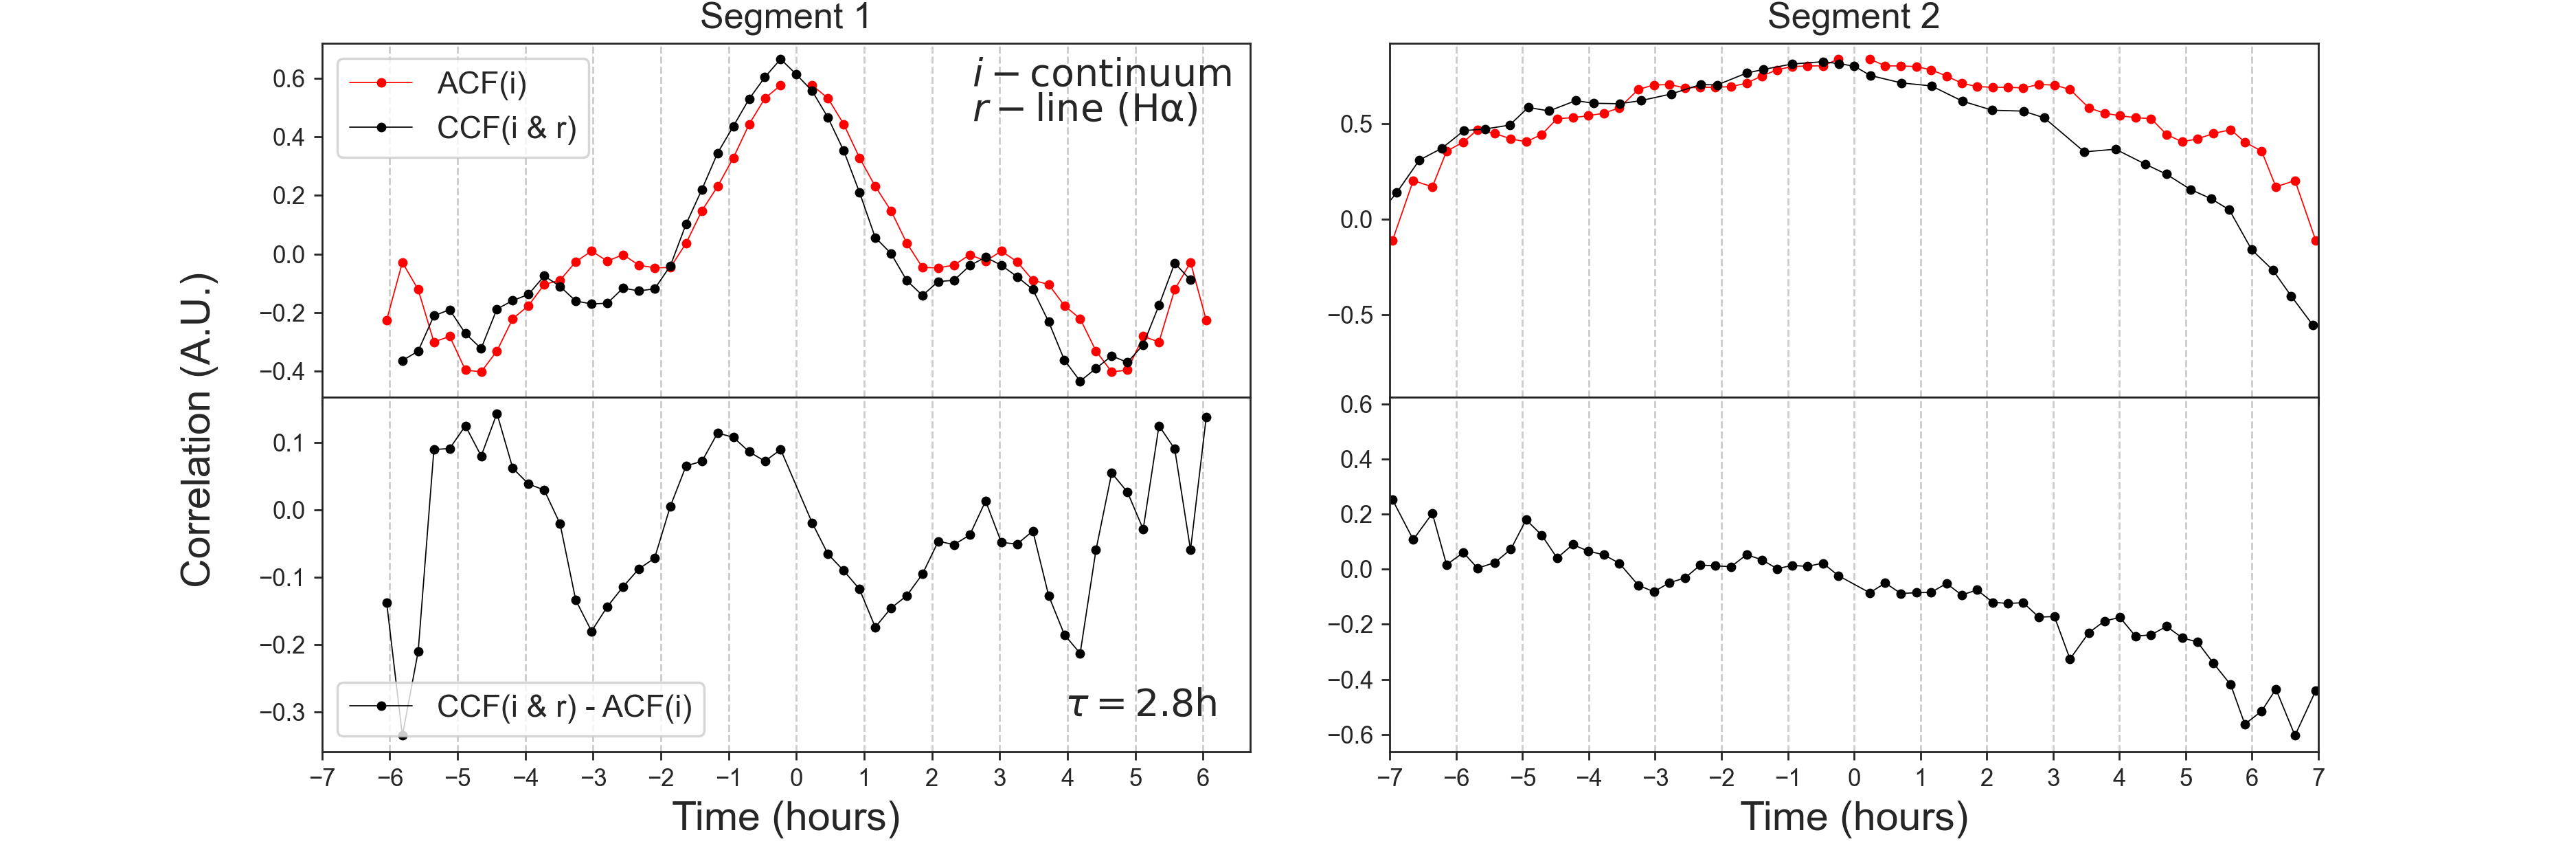

In [12]:
display.Image("./figs/ir_novo.png")

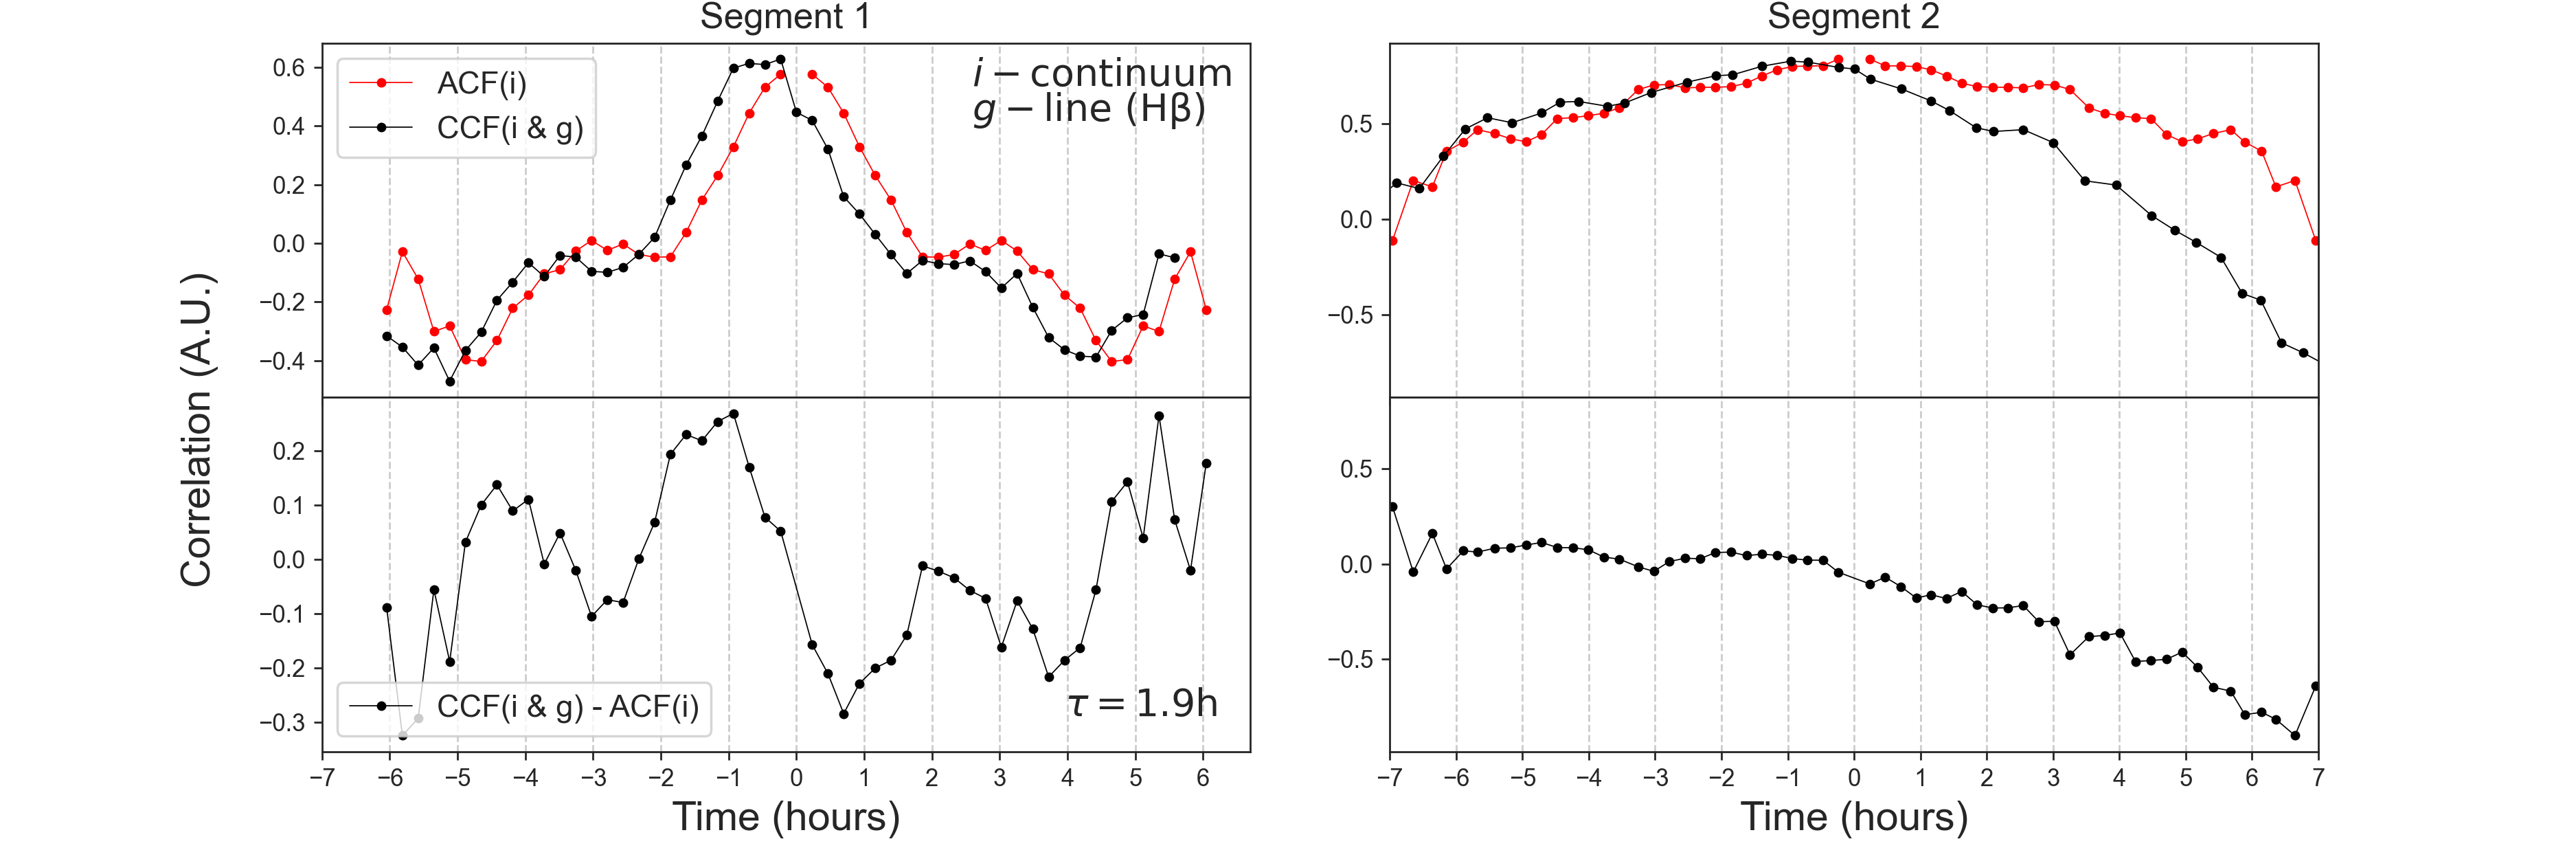

In [13]:
display.Image("./figs/ig_novo.png")

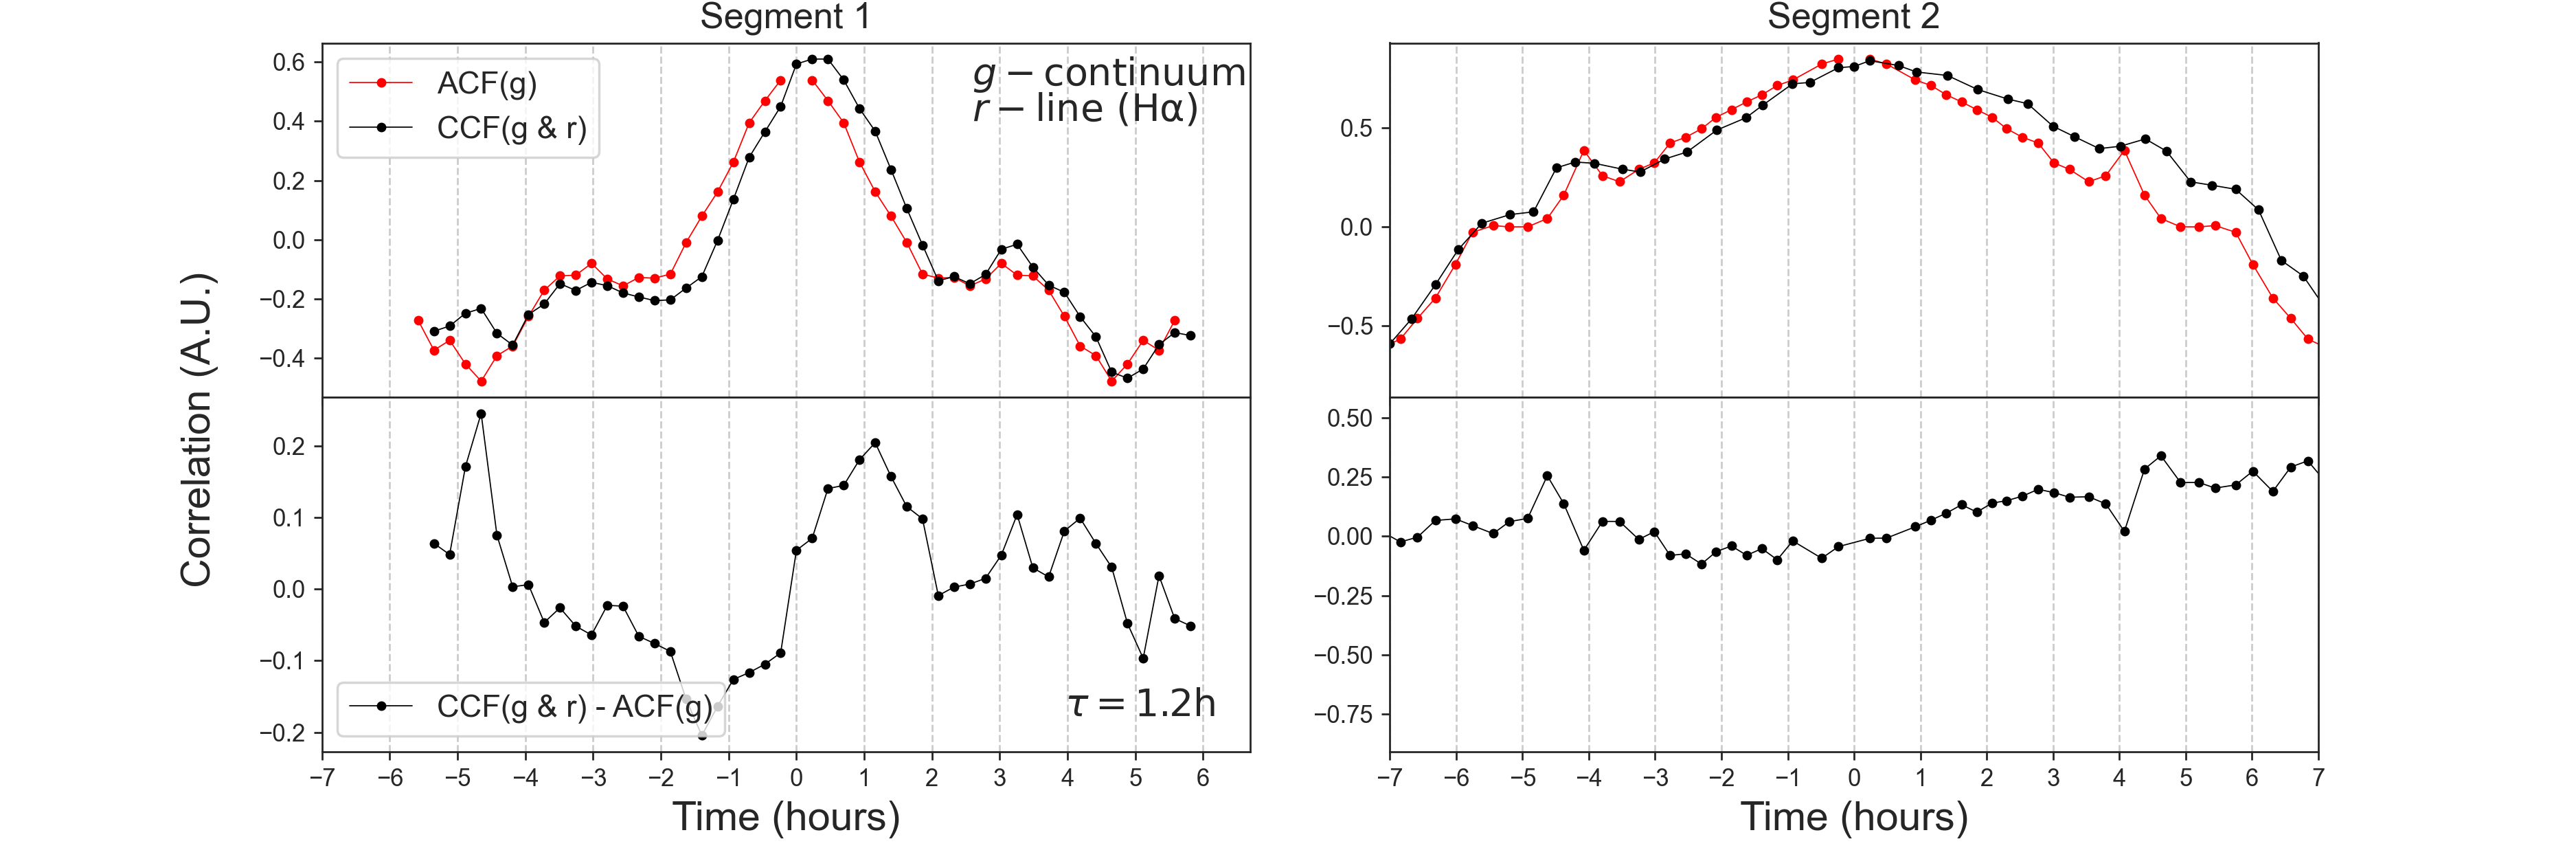

In [14]:
display.Image("./figs/gr_novo.png")

### 5.2 CNN model - 8h

We repeat the same analysis, but now with data obtained from neural network (learned light curve) for first 8h.

In [13]:
# Loading results

ccf_ir = pd.read_csv('results_zdcf_cnn8h/cnn8_i_r_ccf.dcf', sep=" ", header=None, skipinitialspace=True)
ccf_gr = pd.read_csv('results_zdcf_cnn8h/cnn8_g_r_ccf.dcf', sep=" ", header=None, skipinitialspace=True)
ccf_ig = pd.read_csv('results_zdcf_cnn8h/cnn8_i_g_ccf.dcf', sep=" ", header=None, skipinitialspace=True)

acf_i = pd.read_csv('results_zdcf_cnn8h/cnn8_i_acc.dcf', sep=" ", header=None, skipinitialspace=True)
acf_g = pd.read_csv('results_zdcf_cnn8h/cnn8_g_acc.dcf', sep=" ", header=None, skipinitialspace=True)
acf_r = pd.read_csv('results_zdcf_cnn8h/cnn8_r_acc.dcf', sep=" ", header=None, skipinitialspace=True)

ccfs = [ccf_ir, ccf_gr, ccf_ig]
acfs = [acf_i, acf_g, acf_r]

# Defining columns
cols = ['tau', '-sig(tau)', '+sig(tau)', 'dcf', '-err(dcf)', '+err(dcf)', '#bin']

for ccf,acf in zip(ccfs,acfs):
    ccf.columns = cols
    acf.columns = cols

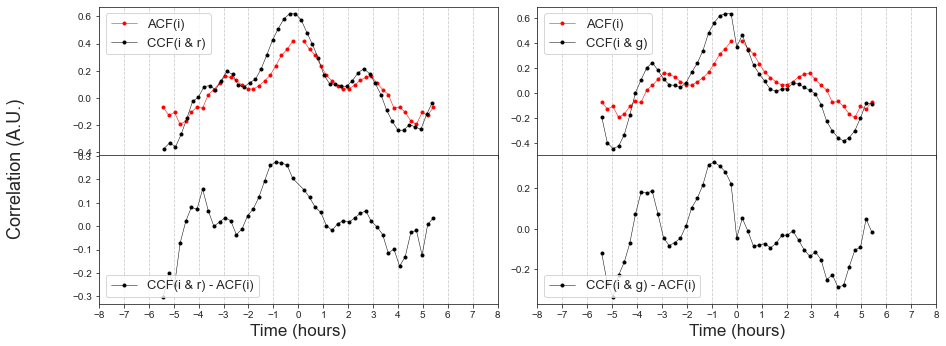

In [5]:
acfss = [acf_i,acf_i]
ccfss = [ccf_ir,ccf_ig]

photRM.plot_ccf_acf2(acfss,ccfss, labels1=['ACF(i)','ACF(i)'], labels2=['CCF(i & r)', 'CCF(i & g)'])

In [7]:
photRM.find_tau(acf_i,ccf_ir)

[1.807, 2.711, 3.84, 4.743]

In [8]:
photRM.find_tau(acf_i,ccf_ig)

[0.2254, 1.129, 2.258, 3.162, 3.839, 5.194]

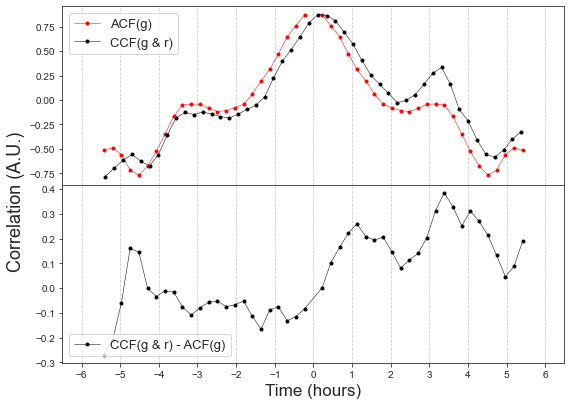

In [14]:
photRM.plot_ccf_acf(acf_g, ccf_gr, lims=(-6.5,6.5), label1='ACF(g)', label2='CCF(g & r)', locator=1)

Raw estimation of time-lag:
- $\tau \sim 1$h

### 5.3 CNN model 8h + observational data

Here we use ACFs and CCFs which were obtained by running ZDCF on modeled light curve and on observational data. 

In [5]:
# Loading results

ccf_ir = pd.read_csv('results_zdcf_cnn8h/all8_i_r_ccf.dcf', sep=" ", header=None, skipinitialspace=True)
ccf_gr = pd.read_csv('results_zdcf_cnn8h/all8_g_r_ccf.dcf', sep=" ", header=None, skipinitialspace=True)
ccf_ig = pd.read_csv('results_zdcf_cnn8h/all8_i_g_ccf.dcf', sep=" ", header=None, skipinitialspace=True)

acf_i = pd.read_csv('results_zdcf_cnn8h/all8_i_acc.dcf', sep=" ", header=None, skipinitialspace=True)
acf_g = pd.read_csv('results_zdcf_cnn8h/all8_g_acc.dcf', sep=" ", header=None, skipinitialspace=True)
acf_r = pd.read_csv('results_zdcf_cnn8h/all8_r_acc.dcf', sep=" ", header=None, skipinitialspace=True)

ccfs = [ccf_ir, ccf_gr, ccf_ig]
acfs = [acf_i, acf_g, acf_r]

# Defining columns
cols = ['tau', '-sig(tau)', '+sig(tau)', 'dcf', '-err(dcf)', '+err(dcf)', '#bin']

for ccf,acf in zip(ccfs,acfs):
    ccf.columns = cols
    acf.columns = cols

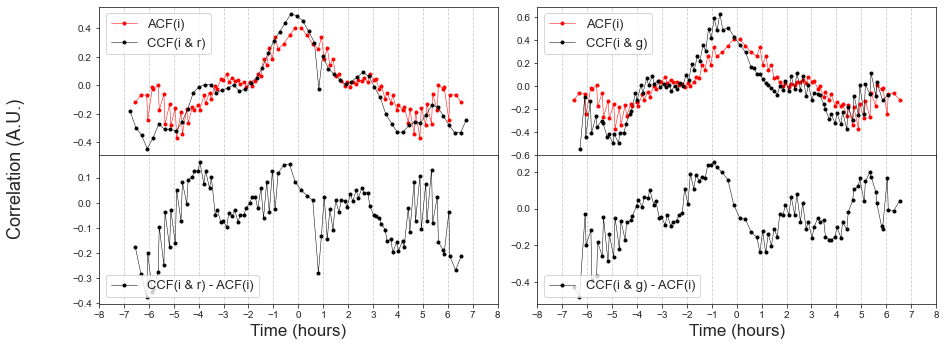

In [12]:
acfss = [acf_i,acf_i]
ccfss = [ccf_ir,ccf_ig]

photRM.plot_ccf_acf2(acfss,ccfss, labels1=['ACF(i)','ACF(i)'], labels2=['CCF(i & r)', 'CCF(i & g)'])

In [17]:
photRM.find_tau(acf_i,ccf_ir)

[1.04,
 1.269,
 1.498,
 1.728,
 2.093,
 2.326,
 2.558,
 2.791,
 3.721,
 3.954,
 4.186,
 4.419,
 4.651,
 4.884,
 5.116,
 5.349,
 5.581,
 6.046]

In [18]:
photRM.find_tau(acf_i,ccf_ig)

[1.04,
 1.269,
 1.498,
 1.728,
 1.957,
 2.186,
 2.415,
 2.645,
 2.874,
 3.256,
 3.488,
 4.02,
 4.249,
 4.937,
 5.349,
 6.046]

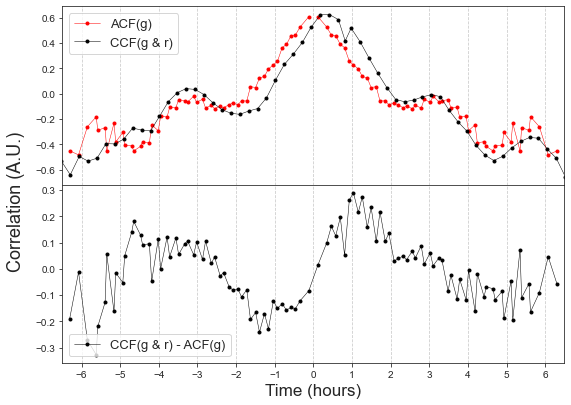

In [24]:
photRM.plot_ccf_acf(acf_g, ccf_gr, lims=(-6.5,6.5), label1='ACF(g)', label2='CCF(g & r)', locator=1)

Raw estimation of time-lag:
- $\tau \sim 1$h